<a href="https://colab.research.google.com/github/deangarcia/NLP/blob/main/NLP_Assignment2_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, you will familiarize yourself with:

    spaCy
    numpy
    PyTorch

to develop

    Multiple sentiment analysis models

to be able to

    Predict whether a given review is positive or negative

Before we begin, make sure your runtime is set to GPU -- 

Runtime > Change runtime type set to GPU

First we will load in some data.

Provided is code that will download a file and rename it to reviews.tar.gz


Included is a vocabulary of all the words we can potentially see -- No '\<UNK\>' *here*

In [1]:
!head aclImdb/imdb.vocab

head: cannot open 'aclImdb/imdb.vocab' for reading: No such file or directory


So, we have 12500 reviews for positive and negative classifications, and 50000 that are unlabeled.  

Looking at the words in a review that don't show up in the vocab, we need to handle punctuation in a more delicate way (also, we will be making everything lower cased).  For this, we will turn to a standard modern NLP library spaCy.  spaCy is a library that handles a number of different low-level NLP tasks like tokenization, part-of-speech recognition, and named entity recognition.  For now, we will be focusing on the tokenization aspect.



In [2]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
!tar -xf aclImdb_v1.tar.gz
positive_reviews = !ls -1 -d aclImdb/train/pos/*
negative_reviews = !ls -1 -d aclImdb/train/neg/*
unsupervised_reviews = !ls -1 -d aclImdb/train/unsup/*

print(positive_reviews[:10])

--2022-03-21 03:05:12--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  30.3MB/s    in 2.6s    

2022-03-21 03:05:15 (30.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

['aclImdb/train/pos/0_9.txt', 'aclImdb/train/pos/10000_8.txt', 'aclImdb/train/pos/10001_10.txt', 'aclImdb/train/pos/10002_7.txt', 'aclImdb/train/pos/10003_8.txt', 'aclImdb/train/pos/10004_8.txt', 'aclImdb/train/pos/10005_7.txt', 'aclImdb/train/pos/10006_7.txt', 'aclImdb/train/pos/10007_7.txt', 'aclImdb/train/pos/10008_7.txt']


In [3]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
!tar -xf aclImdb_v1.tar.gz
positive_reviews = !ls -1 -d aclImdb/train/pos/*
negative_reviews = !ls -1 -d aclImdb/train/neg/*
unsupervised_reviews = !ls -1 -d aclImdb/train/unsup/*

vocabulary = set()
array_review = []

with open('./aclImdb/imdb.vocab') as vocab_file:
  for word in vocab_file:
    vocabulary.add(word.rstrip())

with open(positive_reviews[0]) as review:
  for line in review:
    for word in line.rstrip().split(' '):
      if word not in vocabulary:
        pass
        
from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.Defaults.create_tokenizer(nlp)
counts = {}
rev_count = 0
for review in positive_reviews + negative_reviews:
  array_review.append(rev_count)
  rev_count = rev_count + 1
  with open(review) as review:
    for line in review:
      for word in tokenizer(line.rstrip().lower()):
        if word.text not in vocabulary:
          pass
        else:
          counts[word.text] = counts.get(word.text,0) + 1

# The whole vocabulary needs to be setup so the words that appear most often are at the beggining of the set
# so we need this extra array to organize our vocabulary
count2words = {}
for word in counts:
  count = counts[word]
  if count not in count2words:
    count2words[count] = []
  count2words[count].append(word)

running_total = 0
vocabulary = []
for count in reversed(sorted(count2words)):
  running_total += len(count2words[count])
  vocabulary += count2words[count]
  if running_total > 10000:
    break

--2022-03-21 03:05:33--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  34.7MB/s    in 2.3s    

2022-03-21 03:05:35 (34.7 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



We can now tokenize our text and the things we ignore are *mostly* puncutation (most tokenizers will split contractions like I'm into I and 'm which happens here, but the original vocab doesn't expect -- we will just let that happen here)


#Step 1

Fill out the function below to:

* Tokenize a document
* Extract all n-grams and their counts of the given order

* It's ok to utilize your work from the first assignment here (although use SpaCy and go to lower case)

In [4]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

def get_n_grams(filename,n):
  ngrams = {}
  texts = []
  test = []

  filex = open(filename,'r')
  tokens = tokenizer(filex.read())
  for token in tokens:
    test.append(token.lemma_.lower())
  texts.append(test)
  #Text is a list of lists
  for text in texts:
    # iterate through each list (-n + 1 because of the nested for loop we dont want to go out of range and len(array) doesnt take into account 0)
    for i in range(len(text) - n + 1):
      temp = [] 
      # now iterate through the list j values which is the length of n to save our string values into a tuple
      for j in range(n):
        temp.append(text[i+j])
      tuple_temp = tuple(temp)
      # save the tuple as a key at increment it by one if it exists already 
      if tuple_temp in ngrams.keys():
        ngrams[tuple_temp] += 1
      # or set it to one on the first occurence
      else:
        ngrams[tuple_temp] = 1

  return ngrams


We are going to use Stochastic Gradient Descent to learn the weights for our regression, and we will be utilizing the PyTorch library to do so

In [6]:
import torch
import torch.nn as nn

With the ability to extract out n-grams, we will now be constructing a linear classifier.  To do this, we will need to set up our data.  

#Step 2

* Make a $|D|\times|unigrams|$ tensor (`torch.Tensor`) , `X_unigrams` that contains all of the unigram counts for the documents -- each row should be a document and each column should be a unigram -- each cell corresponding to the number of times the unigram corresponding to the column shows up in the document corresponding to the row  
i.e., $X_{unigrams}[i,j] = $ Count of unigram $j$ in document $i$
* Make a $|D|\times1$ tensor, `Y` that contains the ratings for the documents -- we will say that a positive review has a rating of `1` and a negative review is `0`
*In torch, if we want to use a GPU for the training we need to move the data to the GPU using `.to('cuda')`.  For this to work you will need to make sure you are using a GPU instance (Runtime > Change Runtime Type > Hardware Accelerator = GPU)

In [7]:
n = 1
if torch.cuda.is_available():
  device = torch.device("cuda") 
data = []
ratings = []
for filename in positive_reviews + negative_reviews:
  substring = "pos"
  rating_val = []
  if substring in filename:
    ratings.append(1)
  else:
    ratings.append(0)
  row_data = []
  gram = get_n_grams(filename, n)
  for i in range(len(vocabulary)):
    temp_list = []
    for j in range(n):
      temp_list.append(vocabulary[i])
    cmp_tuple = tuple(temp_list)
    if cmp_tuple in gram.keys():
      row_data.append(gram[cmp_tuple])
    else:
      row_data.append(0)
  data.append(row_data)

if torch.cuda.is_available():
  device = torch.device("cuda")
  X_unigrams = torch.FloatTensor(data).to(device)
  y = torch.FloatTensor(ratings).to(device)
  y = y.view(y.shape[0], 1)

print(X_unigrams) # not sure if the data model is setup correctly here how would we do a bigram or trigram?
print(y)



tensor([[ 9.,  1.,  4.,  ...,  0.,  0.,  0.],
        [24.,  4., 17.,  ...,  0.,  0.,  0.],
        [10.,  4.,  6.,  ...,  0.,  0.,  0.],
        ...,
        [12.,  8.,  7.,  ...,  0.,  0.,  0.],
        [ 9.,  5., 12.,  ...,  0.,  0.,  0.],
        [10.,  1.,  5.,  ...,  0.,  0.,  0.]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [ ]:
print(X_unigrams[-500:])
print(y[-500:])
print(len(array_review))

We will first construct a module that does what we want.  In torch you implement modules and you define the forward pass of the model (Torch uses autograd to automatically compute the backward pass based on the forward pass). 

#Step 3
* Implement the linear regression using Torch
* You will want to use a `torch.nn.Linear` layer -- The linear layer is essentially a matrix multiplication as shown in class  -- think about what the input dimension and output dimensions should be (how big is our input, how many things are we predicting)


In [14]:
class LinearRegression(nn.Module):
  def __init__(self, size):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(size , 1)

  def forward(self,X):
    out = self.linear(X)
    return out

With the above model, we now need to actually train it.  We are going to use a pretty simple training regimen here.

#Step 4 
* Create the optimizer -- I recommend using the Adam optimizer (`optim.Adam`) -- optimizers take in the parameters that they are optimizing (`model.parameters`) and other hyperparameters like the learning rate (`lr=learning_rate`)
* Loop for the number of `epochs` supplied to the training code -- this will be the number of passes over our data
* In each epoch we will loop over the data in batches -- go from 0 up to the size of `X` in steps of size `batch_size`
* Within each training step we will need to follow the steps of training a neural network:
 * Zero out the gradients in the optimizer (by default the gradients are kept around) by calling `.zero_grad()` on the optimizer
 * Get the current batch -- we can use *slicing* to get certain elements in our input and output.  E.g. `X[i:i+step_size,:]` would return a Tensor with elements from X from row i to row i+step_size and all of the columns
 * Run the model on the batch making sure to assign the result to a variable -- you can either call `.forward(...)` or more simply just call the model `(...)`
 * Calculate the loss of the output -- this is done by calling the `loss_criterion` with the predicted values and the true values as the first and second arguments respectively
 * Run the loss in the backward direction -- Call `.backward()` on the loss calcualted in the previous step
 * Step the optimizer -- Call `.step()` on the optimizer
 * You might want to do something like log the value of the loss -- this can be gotten by calling `.item()` on the loss calculated above -- perhaps do this every 5, 10, 50, 100, 500 epochs (your choice)

In [37]:
import torch.optim as optim


def train(X, Y, model, batch_size, epochs, learning_rate, loss_criterion):
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# dont count first array in the D x UNigram  tensor 
  for epoch in range(epochs + 1):
    i = 0
    for step_size in range(int(len(Y)/batch_size)):
      optimizer.zero_grad()
      output = model(X[i:i+step_size,:])
      loss = loss_criterion(output, Y[i:i+step_size,:])
      loss.backward()
      optimizer.step()
      i = i + batch_size
    if epoch % 500 == 1:
      print(f'epoch {epoch} / {epochs}, step {step_size} / {batch_size}, loss = {loss.item():.4f}')


#Step 5
* Construct your model 
* Just as with the data above, if you want to use a GPU we have to tell torch to move the model (and parameters to the gpu) so you need to call `.to('cuda')` (Note this does not change the original model, it returns a model on the gpu so you probably want to do something like `model = model.to('cuda')`
* Call the above training code -- watch how the loss changes as the model trains -- experiment with different training hyperparameters -- learning rate and epoch -- see when the model hits a minima
* For a linear regression, we are using Mean Square Error as our loss `torch.nn.MSELoss`

epoch 1 / 2500, step 4 / 5000, loss = 0.2286
epoch 501 / 2500, step 4 / 5000, loss = 0.0001
epoch 1001 / 2500, step 4 / 5000, loss = 0.0000
epoch 1501 / 2500, step 4 / 5000, loss = 0.0000
epoch 2001 / 2500, step 4 / 5000, loss = 0.0000


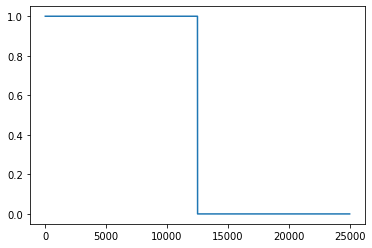

In [41]:
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device("cuda")

# Why is my first array empty
  linear_model = LinearRegression(len(vocabulary)).to(device)

  # How many times do we pass the training data over the over network
  epochs = 2500

  #If the data is to big to pass at once due to computer limitations pass it in
  #smaller batches
  batch_size = 5000
  # Whenever you do learning and i goes over the learning rate if it reaches a minima and starts going up again reduce learning rate
  learning_rate = 0.001
  loss_criterion = nn.MSELoss()
  train(X_unigrams, y, linear_model, batch_size, epochs, learning_rate, loss_criterion)
  predicted = linear_model(X_unigrams).cpu().detach().numpy()
  plt.plot(array_review, predicted)
  plt.plot(array_review, ratings)
  plt.show()

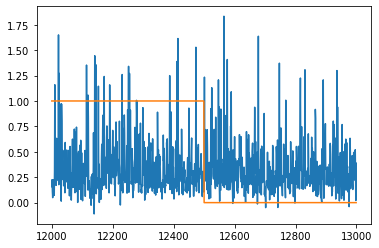

In [45]:
plt.plot(array_review[12000:13000], predicted[12000:13000])
plt.plot(array_review[12000:13000], ratings[12000:13000])
# calculate mean square loss
plt.show()


#Step 6
* Implement the class below -- you should have two linear weights  (Input -> Hidden), (Hidden -> Output)
* In your forward, make sure you apply a nonlinear activation function after going from (Input -> Hidden) before (Hidden -> Output) -- you can choose the nonlinear activation (sigmoid, tanh, relu, leaky-relu are all fine)
* Train the model

###Question 2
How does this model compare to the above model?

In [31]:
class NonLinearRegression(nn.Module):
  def __init__(self, size, hidden_size):
    super(NonLinearRegression, self).__init__()
    self.non_linear = nn.Linear(size , hidden_size).to(device)
    self.relu = nn.ReLU()
    self.non_linear_2 = nn.Linear(hidden_size , 1).to(device)
    self.sigmoid = nn.Sigmoid()

  def forward(self,X):
    out = self.non_linear(X).to(device)
    out = self.relu(out).to(device)
    out = self.non_linear_2(out).to(device)
    out = self.sigmoid(out).to(device)
    return out

In [49]:
if torch.cuda.is_available():
  device = torch.device("cuda")

hidden_size = ((len(vocabulary) * 2) / 3) + 1
hidden_size = int(hidden_size)
nonlinear_model = NonLinearRegression(len(vocabulary), hidden_size).to(device)

epochs = 2500
batch_size = 5000 # what is the purpose of the batches?
learning_rate = 0.0001 # what does this variable do?
loss_criterion = nn.MSELoss()
train(X_unigrams, y, nonlinear_model, batch_size, epochs, learning_rate, loss_criterion)

epoch 1 / 2500, step 4 / 5000, loss = 0.2326
epoch 501 / 2500, step 4 / 5000, loss = 0.0000
epoch 1001 / 2500, step 4 / 5000, loss = 0.0000
epoch 1501 / 2500, step 4 / 5000, loss = 0.0000
epoch 2001 / 2500, step 4 / 5000, loss = 0.0000


Ok, we have a linear regression and a non-linear regression -- let's do a Logistic Regression and non-linear Logistic regression now:
#Step 7
* Implement a standard logistic regression and a logistic regression with a hidden layer and non-linear activation
* These should be very similar to above except they should have `torch.Sigmoid` applied to the output
* Note, `MSELoss` is no longer applicable here -- we need to use Binary Cross Entropy Loss `torch.nn.BCELoss`

In [46]:
class LogisticRegression(nn.Module):
  def __init__(self, size):
    super(LogisticRegression, self).__init__()
    self.logistic = nn.Linear(size, 1)

  def forward(self,X):
    out = torch.sigmoid(self.logistic(X))
    return out


class LogisticANN(nn.Module):
  def __init__(self, size, hidden_size):
    super(LogisticANN, self).__init__()
    self.non_linear = nn.Linear(size , hidden_size).to(device)
    self.relu = nn.ReLU()
    self.non_linear_2 = nn.Linear(hidden_size , 1).to(device)
    self.sigmoid = nn.Sigmoid()

  def forward(self,X):
    out = self.non_linear(X).to(device)
    out = self.relu(out).to(device)
    out = self.non_linear_2(out).to(device)
    out = self.sigmoid(out).to(device)
    return out

In [48]:
if torch.cuda.is_available():
  device = torch.device("cuda")

logistic_reg_model = LogisticRegression(len(vocabulary)).to(device)

epochs = 2500
batch_size = 5000 # what is the purpose of the batches?
learning_rate = 0.001 # what does this variable do?
loss_criterion = nn.BCELoss()
train(X_unigrams, y, logistic_reg_model, batch_size, epochs, learning_rate, loss_criterion)

hidden_size = ((len(vocabulary) * 2) / 3) + 1
hidden_size = int(hidden_size)
logisticann_model = LogisticANN(len(vocabulary), hidden_size).to(device)

epochs = 2500
batch_size = 5000 # what is the purpose of the batches?
learning_rate = 0.001 # what does this variable do?
loss_criterion = nn.BCELoss()
train(X_unigrams, y, logisticann_model, batch_size, epochs, learning_rate, loss_criterion)

epoch 1 / 2500, step 4 / 5000, loss = 0.7702
epoch 501 / 2500, step 4 / 5000, loss = 0.0005
epoch 1001 / 2500, step 4 / 5000, loss = 0.0001
epoch 1501 / 2500, step 4 / 5000, loss = 0.0000
epoch 2001 / 2500, step 4 / 5000, loss = 0.0000
epoch 1 / 2500, step 4 / 5000, loss = 0.0532
epoch 501 / 2500, step 4 / 5000, loss = 0.0000
epoch 1001 / 2500, step 4 / 5000, loss = 0.0000
epoch 1501 / 2500, step 4 / 5000, loss = 0.0000
epoch 2001 / 2500, step 4 / 5000, loss = 0.0000


In [55]:
import math

linear_predictions = linear_model(X_unigrams)
non_linear_predictions = nonlinear_model(X_unigrams)
logistic_predictions = logistic_reg_model(X_unigrams)
ANN_predictions = logisticann_model(X_unigrams)

loss_temp = nn.MSELoss()
print('\n Positive \n')
print(math.sqrt(loss_temp(linear_predictions[0:12500], y[0:12500]).item()))
print(math.sqrt(loss_temp(non_linear_predictions[0:12500], y[0:12500]).item()))
print(math.sqrt(loss_temp(logistic_predictions[0:12500], y[0:12500]).item()))
print(math.sqrt(loss_temp(ANN_predictions[0:12500], y[0:12500]).item()))

print('\n Negative \n')
print(math.sqrt(loss_temp(linear_predictions[12500:], y[12500:]).item()))
print(math.sqrt(loss_temp(non_linear_predictions[12500:], y[12500:]).item()))
print(math.sqrt(loss_temp(logistic_predictions[12500:], y[12500:]).item()))
print(math.sqrt(loss_temp(ANN_predictions[12500:], y[12500:]).item()))


 Positive 

0.7045249776926907
0.7766169692035182
0.8132705702433165
0.9223528771043374

 Negative 

0.4380610478916339
0.24219239906770426
0.2227832866794458
0.1313350770733905


# Step 8
* This step is somewhat freeform -- just as it would be if you were doing exploratory resarch
* Try doing some exploration of different models.  Some things you might try are:
 * different configurations of inputs (different order n-grams, combinations of n-grams)
 * different numbers and sizes of input layers
 * different non-linear activations

* Normally, you should pick the model that does the best not on training data, but on the evaluation data.  Since this dataset doesn't come with an evaluation set, we will instead be using the test set as our evaluation set (this is obviously poor practice, and should not be done in the real world).  Or rather we will be using a portion of the test files as evaluation.

* Pick a model architecture, train it, run it on the eval data 
* Do this multiple times, keep the best model 

#### Question 3:
How do you pick the "best" model -- what metric do you want to use here?

* As a note, there will be n-grams that show up in the evaluation and training sets that don't show up in the training data, you will have to be able to account for this (of course, ignoring is acceptable) but your code shouldn't fail


In [ ]:
positive_raw_test = !ls -1 -d aclImdb/test/pos/*
negative_raw_test = !ls -1 -d aclImdb/test/neg/*

positive_eval = positive_raw_test[:len(positive_raw_test)//4]
negative_eval = negative_raw_test[:len(negative_raw_test)//4]
positive_test = positive_raw_test[len(positive_raw_test)//4:]
negative_test = negative_raw_test[len(negative_raw_test)//4:]


print(len(positive_eval))
print(len(negative_eval))
print(len(positive_test))
print(len(negative_test))


3125
3125
9375
9375


In [ ]:
n_correct = 0
n_samples = 0
n_test = 1
for reviews_test in negative_reviews:
  row_data_test = []
  gram_test = get_n_grams(reviews_test, n)
  for i in range(len(vocabulary)):
    temp_list_test = []
    for j in range(n):
      temp_list_test.append(vocabulary[i])
    cmp_tuple_test = tuple(temp_list_test)
    if cmp_tuple_test in gram_test.keys():
      row_data_test.append(gram_test[cmp_tuple_test])
    else:
      row_data_test.append(0)
  if torch.cuda.is_available():
    device = torch.device("cuda")
    test = torch.FloatTensor(row_data_test).to(device)
  outputs_test = linear_model(test)
  print(outputs_test)
  _, predictions = torch.max(outputs_test, 0)


tensor([0.3983], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.4392], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.5049], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6822], device='cuda:0', grad_fn=<AddBackward0>)
tensor([1.1739], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.3390], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6165], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.9546], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6699], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.2581], device='cuda:0', grad_fn=<AddBackward0>)
tensor([1.0071], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.9599], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.4394], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.4215], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.8162], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.3522], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.3490], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6701

KeyboardInterrupt: ignored

## Bonus: Augment with unsupervised data
* The dataset comes with more unsupervised data than supervised -- come up with a way to augment your training set with the unsupervised data, such that your model performance improves (to do this comparison keep model architecture the same, and compare the augmented data model vs the original on the evaluation set)